In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import time
import datetime
import logging
import shutil
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re


sns.set_style("whitegrid")

# read model log file

In [2]:
path = '/home/jeronimo/git/AUT-CNN-TUB/Data/Models/model_merge_3CONV_3P_MEMORY_56_b50_s53256_2018-09-25_20-49/model.log'
export_dir =  os.path.join(path.split('model.log')[0], 'simple_save')
with open(path) as f:
    f = f.readlines()

# parse log file

In [3]:
export_dir

'/home/jeronimo/git/AUT-CNN-TUB/Data/Models/model_merge_3CONV_3P_MEMORY_56_b50_s53256_2018-09-25_20-49/simple_save'

In [4]:
steps_entro_train = []
steps_ac_train = []
steps_entro_val = []
steps_ac_val = []
step = []
epoch = []
epoch_entro_test = []
epoch_ac_test = []
epoch_ac_train = []

for line in f:
    if 'step' in line:
        if 'validation cross entropy' in line:
            step.append(int(line.split('step')[1].split(',')[0]))
            steps_entro_val.append(float(line.split('validation cross entropy ')[-1][:-1]))
            
        elif 'validation accuracy' in line:
            steps_ac_val.append(float(line.split('validation accuracy ')[-1][:-1]))
            
        elif 'train accuracy' in line:
            steps_ac_train.append(float(line.split('train accuracy ')[-1][:-1]))
        elif 'train cross entropy' in line:
            steps_entro_train.append(float(line.split('train cross entropy ')[-1][:-1]))
            
            
            
            
    elif 'epoch' in line:
        if 'test accuracy' in line:    
            epoch.append(int(line.split('epoch')[1].split(',')[0]))
            epoch_ac_test.append(float(line.split('test accuracy ')[1][:-1]))
        elif 'training accuracy' in line:
            epoch_ac_train.append(float(line.split('training accuracy ')[1][:-1]))
        elif 'cross' in line:
            epoch_entro_test.append(float(line.split('cross entropy ')[-1][:-1]))

In [5]:
value_list = []
parameter_list = ['ARCHITECTURE', 'MINIBATCH_SIZE','STEPS', 'PIXEL', 'COLOR', 'CONV',
                  'EPOCH',  'CONV1_DEPTH']

for parameter in parameter_list:
    try:
        value_list.append(re.findall('(?<={}:\s)\w+'.format(parameter), f[0])[0])
    except:
        value_list.append('?')
for line in f:
    
    if 'DROP_KEEP' in line:
        value_list.append(float(re.findall('(?<=DROP_KEEP: )\d+.\d+', line)[0]))
        parameter_list.append('DROP_KEEP')
        
    if 'Model training took'in line:
        value_list.append(float(re.findall('(?<=Model training took, )\d+.\d+', line)[0]) / 60)
        parameter_list.append('RUNTIME')
    if 'test accuracy'in line:
        try:
            value_list.append(round(float(re.findall('(?<=test accuracy: )\d.\d+', line)[0]),5))
        except:
            value_list.append('?')
        parameter_list.append('TEST_ACCURACY')
    if 'LEARNING'in line:
        try:
            value_list.append(re.findall('(?<=LEARNING: )\d.\d+', line)[0])
        except:
            value_list.append('?')
        parameter_list.append('LEARNING')
    
        
value_list.append(f[0].split(' - root -')[0])
parameter_list.append('START_TIME')

df_parameter = pd.DataFrame(data=value_list, index=parameter_list, columns=[''])
df_parameter.to_csv(path.split('model.log')[0]+'table.csv')

# default graph

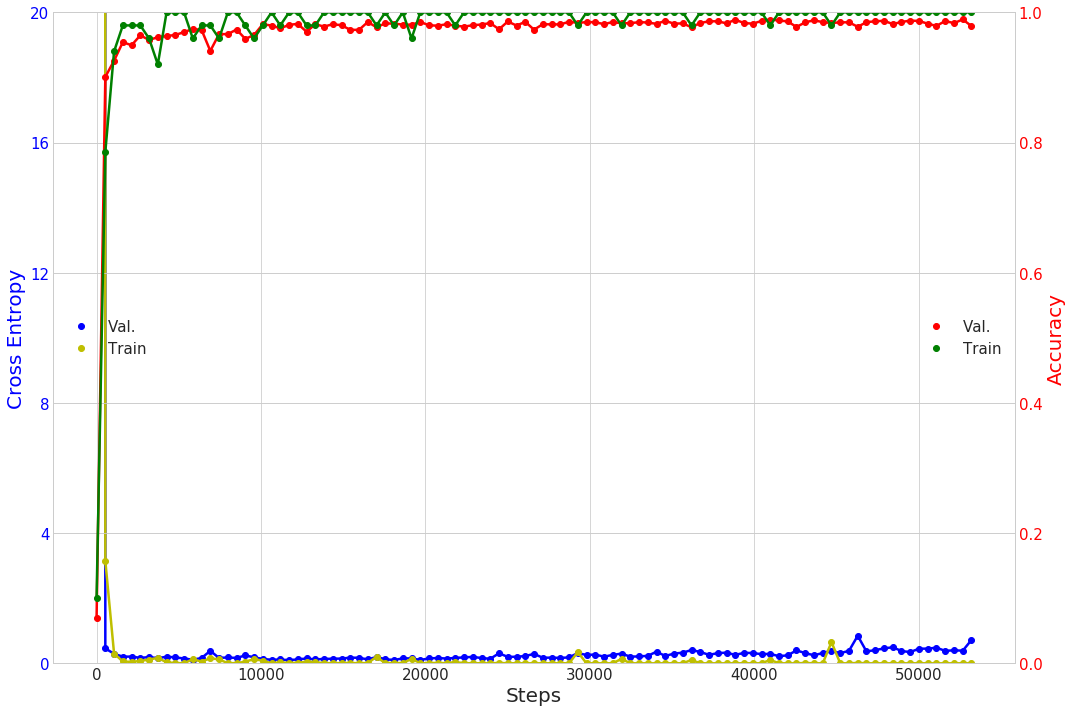

In [6]:

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(step, steps_entro_val, 'bo', label='Val.' )
ax1.plot(step, steps_entro_val, 'b', lw= 2.5)
ax1.plot(step, steps_entro_train, 'yo', label='Train')
ax1.plot(step, steps_entro_train, 'y',  lw= 2.5)
ax1.set_ylim([0,20])
ax1.set_yticks(list(range(0,21, 4)))
#ax1.set_yscale('symlog')
ax1.set_xlabel('Steps').set_fontsize(20)
ax1.tick_params('x', labelsize=15)

ax1.legend(loc=6, fontsize=15)

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('Cross Entropy', color='b').set_fontsize(20)
ax1.tick_params('y', colors='b', labelsize=15)
#ax1.set_yticks([10,5,1,0.5])


ax2 = ax1.twinx()
ax2.set_ylim([0,1])
#ax2.set_yscale('log')
ax2.plot(step, steps_ac_val, 'ro', label='Val.')
ax2.plot(step, steps_ac_val, 'r', lw= 2.5)

ax2.plot(step, steps_ac_train, 'go', label='Train')
ax2.plot(step, steps_ac_train, 'g',  lw= 2.5)
ax2.set_ylabel('Accuracy', color='r').set_fontsize(20)

ax2.tick_params('y', colors='r', labelsize=15)

ax2.legend(loc=7, fontsize=15)
fig.tight_layout()
plt.savefig(path.split('model.log')[0]+'graph')
plt.show()
plt.close()

# zoomed graph, if CNN has high accuracy

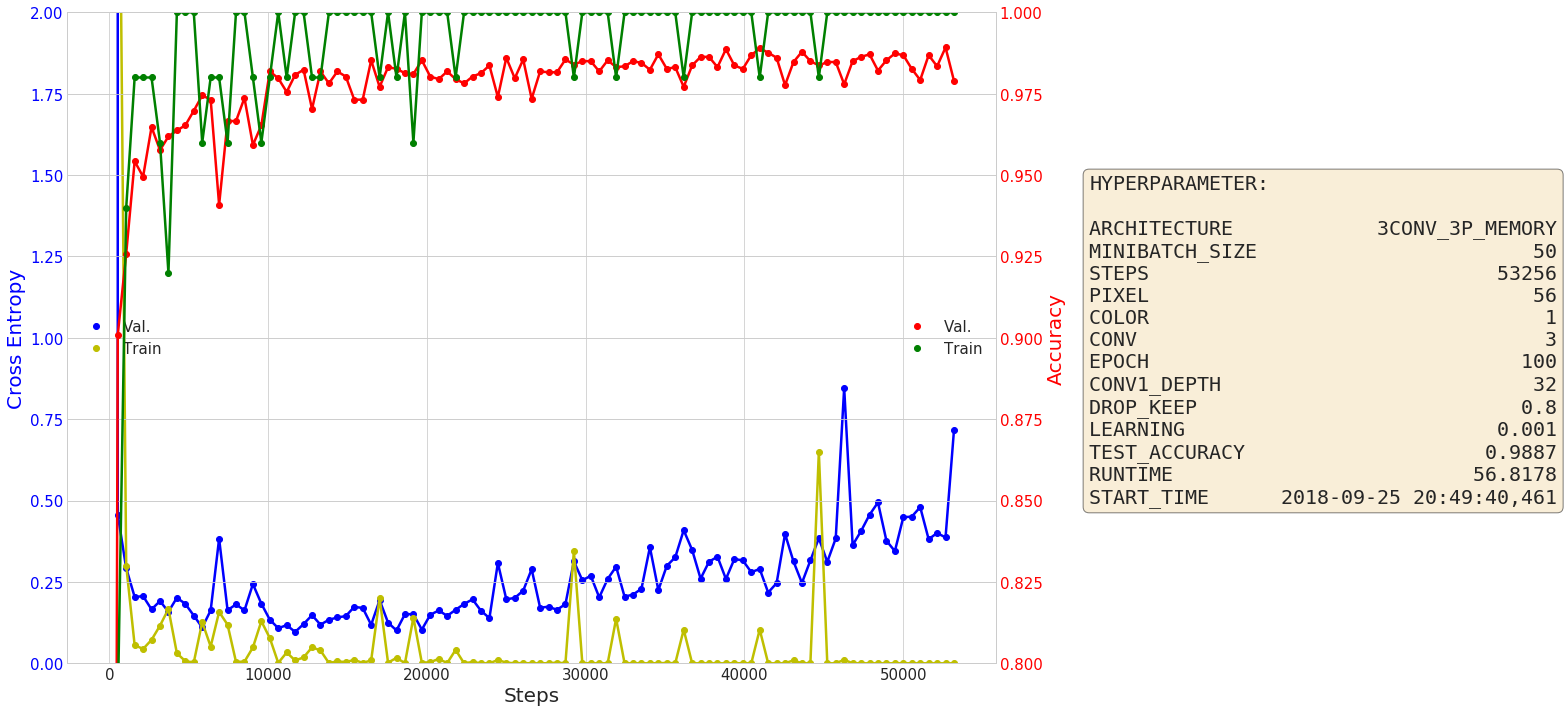

In [7]:

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(step, steps_entro_val, 'bo', label='Val.' )
ax1.plot(step, steps_entro_val, 'b', lw= 2.5)
ax1.plot(step, steps_entro_train, 'yo', label='Train')
ax1.plot(step, steps_entro_train, 'y',  lw= 2.5)
ax1.set_ylim([0,2])
#ax1.set_yticks(list(range(0,21, 4)))
#ax1.set_yscale('log')
ax1.set_xlabel('Steps').set_fontsize(20)
ax1.tick_params('x', labelsize=15)

ax1.legend(loc=6, fontsize=15)

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('Cross Entropy', color='b').set_fontsize(20)
ax1.tick_params('y', colors='b', labelsize=15)
#ax1.set_yticks([10,5,1,0.5])


ax2 = ax1.twinx()
ax2.set_ylim([0.8,1])
#ax2.set_yscale('log')
#ax2.invert_yaxis()
ax2.plot(step,(steps_ac_val), 'ro', label='Val.')
ax2.plot(step,(steps_ac_val), 'r', lw= 2.5)

ax2.plot(step,(steps_ac_train), 'go', label='Train')
ax2.plot(step,(steps_ac_train), 'g',  lw= 2.5)
ax2.set_ylabel('Accuracy', color='r').set_fontsize(20)

ax2.tick_params('y', colors='r', labelsize=15)
ax2.legend(loc=7, fontsize=15)
fig.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.text(1.1,0.75, 'HYPERPARAMETER:\n' + df_parameter.to_string(), transform=ax2.transAxes, fontsize=20, family='monospace',
        verticalalignment='top', bbox=props)

plt.savefig(path.split('model.log')[0]+'graph_zoom_data', bbox_inches='tight', pad_inches= 0.5)
plt.show()

# default graph with hyperparameter

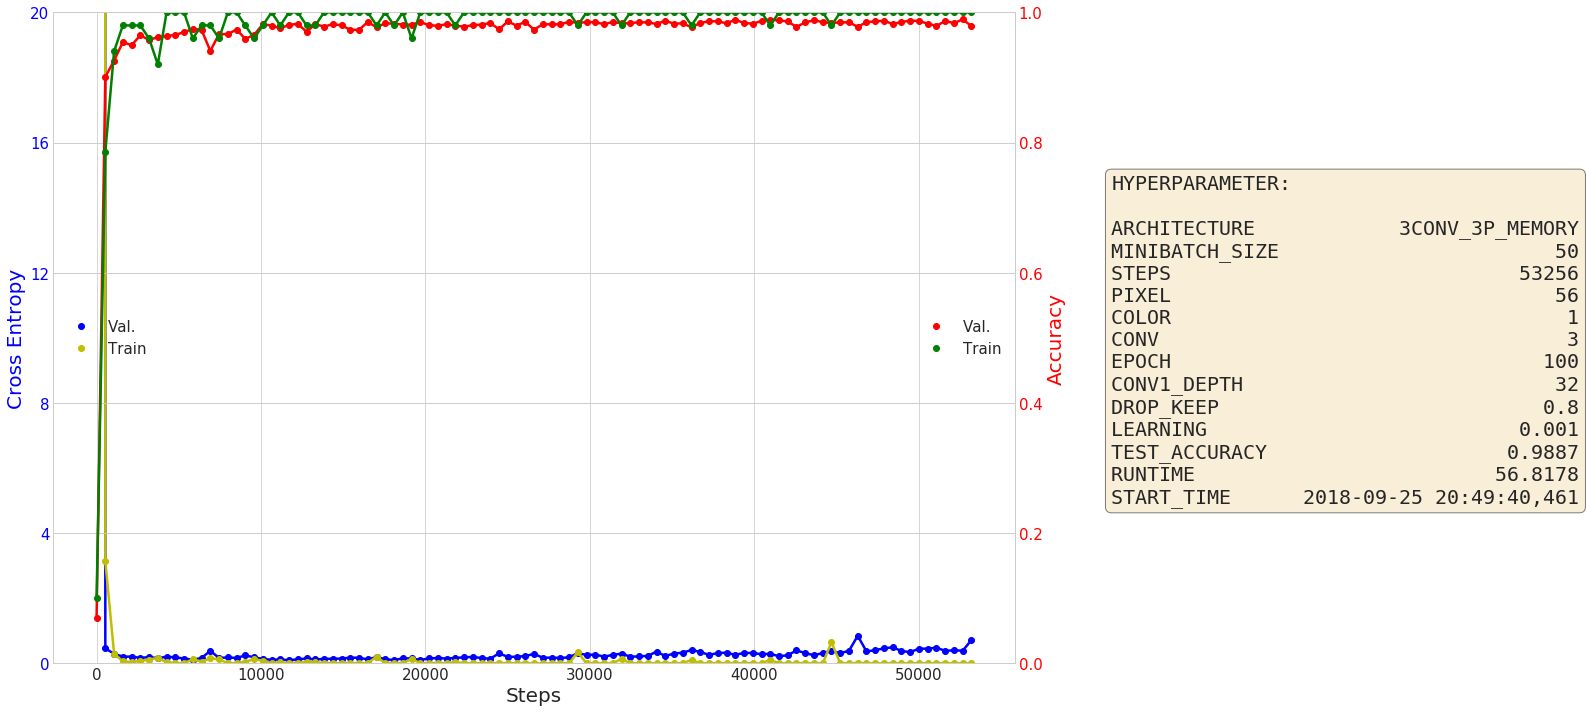

In [8]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(step, steps_entro_val, 'bo', label='Val.' )
ax1.plot(step, steps_entro_val, 'b', lw= 2.5)
ax1.plot(step, steps_entro_train, 'yo', label='Train')
ax1.plot(step, steps_entro_train, 'y',  lw= 2.5)
ax1.set_ylim([0,20])
ax1.set_yticks(list(range(0,21, 4)))
#ax1.set_yscale('symlog')
ax1.set_xlabel('Steps').set_fontsize(20)
ax1.tick_params('x', labelsize=15)

ax1.legend(loc=6, fontsize=15)

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('Cross Entropy', color='b').set_fontsize(20)
ax1.tick_params('y', colors='b', labelsize=15)
#ax1.set_yticks([10,5,1,0.5])


ax2 = ax1.twinx()
ax2.set_ylim([0,1])
#ax2.set_yscale('log')
ax2.plot(step, steps_ac_val, 'ro', label='Val.')
ax2.plot(step, steps_ac_val, 'r', lw= 2.5)

ax2.plot(step, steps_ac_train, 'go', label='Train')
ax2.plot(step, steps_ac_train, 'g',  lw= 2.5)
ax2.set_ylabel('Accuracy', color='r').set_fontsize(20)

ax2.tick_params('y', colors='r', labelsize=15)

ax2.legend(loc=7, fontsize=15)
fig.tight_layout()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.text(1.1,0.75, 'HYPERPARAMETER:\n' + df_parameter.to_string(), transform=ax2.transAxes, fontsize=20, family='monospace',
        verticalalignment='top', bbox=props)

plt.savefig(path.split('model.log')[0]+'graph_data', bbox_inches='tight', pad_inches= 0.5)
plt.show()

# load predictor from model 

In [9]:
home = os.getcwd().split('AUT-CNN-TUB')[0]

COLOR = int(df_parameter.loc['COLOR'].values[0])
PIXEL = int(df_parameter.loc['PIXEL'].values[0]) 

# check chanel
if COLOR is 3:
    Gray = False
elif COLOR is 1:
    Gray = True
else:
    logger.error('COLOR has to be 1 or 3')
#
assert COLOR in [3, 1]

# path to the data set
test_path = os.path.join(home, 'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned/test/'.format(PIXEL))
train_path = os.path.join(home, 'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned/train/'.format(PIXEL))
val_path = os.path.join(home, 'AUT-CNN-TUB/Data/TF_Images_final_{}_cleaned/validate'.format(PIXEL))

# get number of images
test_number = len(os.listdir(test_path))
train_number = len(os.listdir(train_path))
val_number = len(os.listdir(val_path))

# labeling
labels = ['01.0', '02.0', '03.0', '04.0', '05.0', '06.0', '07.1', '07.2',
          '08.0', '09.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0']

position_dict = {k: v for v, k in enumerate(labels)}
label_dict = {v: k for v, k in enumerate(labels)}


def label_to_binary(position_dict , label):
    """
    translate label in one-hot tensor like 03.0 -> [0, 0, 0, 3, 0, ... , 0]

    :param position_dict:
    :param label:
    :return: one-hot tensor
    """
    z = np.zeros(len(position_dict), dtype=int)
    z[position_dict[label]] = 1
    return z


class DataGetter:
    """
    DataGetter loads all images from the given file in  memory and stores it there for fast access.
    With the get_batch function it is possible to randomly draw, the given batch-size without return.
    """
    def __init__(self, path, GRBtoGray=False):
        """
        :param path: path to the image folder, eg. ../test/
        :param GRBtoGray: flag for loading the pictures in grayscale if True
        """

        self.path = path
        self.GRBtoGray = GRBtoGray
        self.batch_indices = None
        self.data_path = os.path.join(self.path, '*g')
        self.files = glob.glob(self.data_path)
        self.num_img = len(self.files)
        self.Data = list(range(0, self.num_img))

        img_list = []
        label_list = []
        label_bin_list = []

        for file_path in self.files:
            if self.GRBtoGray is True:
                img = cv2.imread(file_path, flags=0)
                img = img.reshape(img.shape[0], img.shape[1], 1)
            else:
                img = cv2.imread(file_path, flags=1)

            label_str = file_path.split('/')[-1][:4]
            label_bin = label_to_binary(position_dict, label_str)

            img_list.append(img)
            label_bin_list.append(label_bin)
            label_list.append(file_path.split('/')[-1])

        self.img_list = np.array(img_list)
        self.label_list = np.array(label_list)
        self.label_bin = np.array(label_bin_list)

    def get_batch(self, size):
        """
        :param size: patch size
        :return: (array(images), array(on hot labels), list[file names])
        """
        if len(self.Data) > size:
            self.batch_indices = list(np.random.choice(self.Data, size=size, replace=False))
            for x in self.batch_indices:
                self.Data.remove(x)

        else:  # new epoch
            self.batch_indices = np.random.choice(self.Data, size=len(self.Data), replace=False)
            self.Data = list(range(0, self.num_img))

        return (self.img_list[self.batch_indices],
                self.label_bin[self.batch_indices],
                self.label_list[self.batch_indices].tolist())


# initialise DataGetter object
test_img = DataGetter(test_path, Gray)
train_img = DataGetter(train_path, Gray)
val_img = DataGetter(val_path, Gray)

In [10]:
export_dir= path.split('model.log')[0]+'/simple_save'
predict_fn = tf.contrib.predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from b'/home/jeronimo/git/AUT-CNN-TUB/Data/Models/model_merge_3CONV_3P_MEMORY_56_b50_s53256_2018-09-25_20-49//simple_save/variables/variables'


## load test images

In [11]:
tX_batch, ty_batch, file_name = test_img.get_batch(test_img.num_img)

In [12]:

# make prediction
predictions = predict_fn({'x':tX_batch, 'keep_prob': 1})

In [13]:
df = pd.DataFrame(data=[predictions['predict'].tolist(),  [np.argmax(labels)for labels in ty_batch], file_name]).T
df.columns = ['Prediction', 'Label', 'File']
df.head()

,Prediction,Label,File
0,15,15,15.0.0.0.0043.jpg
1,10,10,10.0.0.1.0160.jpg
2,5,5,06.0.0.1.0173.jpg
3,0,0,01.0.0.1.0212_aug_962.jpg
4,1,1,02.0.0.1.0231.jpg


In [14]:
df_percentage = (df.groupby(['Prediction', 'Label'])['Label'].count().unstack(fill_value=0)/ df.groupby(['Prediction', 'Label'])['Label'].count().unstack(fill_value=0).sum())*100

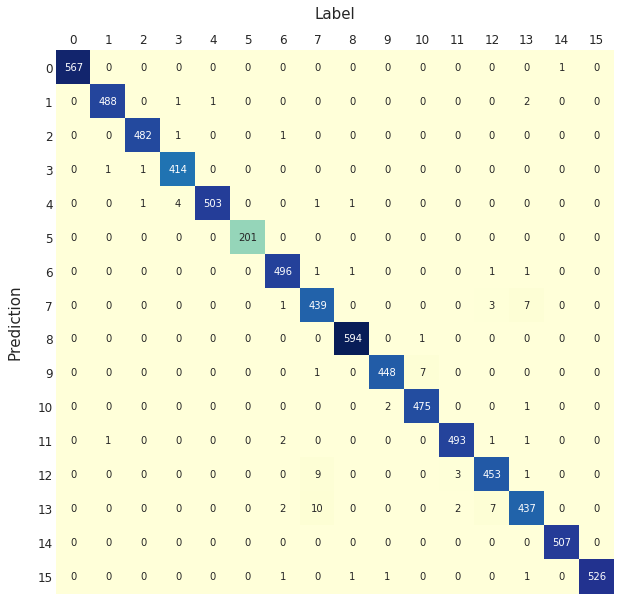

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

graph = sns.heatmap(df.groupby(['Prediction', 'Label'])['Label'].count().unstack(fill_value=0),
            cmap="YlGnBu",
            annot=True, 
            fmt="d",
            cbar=False)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

graph.tick_params(axis='both',labelsize=12) # Tick label size
graph.set_yticklabels(graph.get_yticklabels(), rotation = 0, fontsize = 12)
graph.set_ylabel(graph.get_ylabel(), labelpad=15, fontsize = 15)
graph.set_xlabel(graph.get_xlabel(), labelpad=15, fontsize = 15)
plt.savefig(path.split('model.log')[0]+'confusion_matrix_abs', bbox_inches='tight', pad_inches= 0.5)

plt.show()

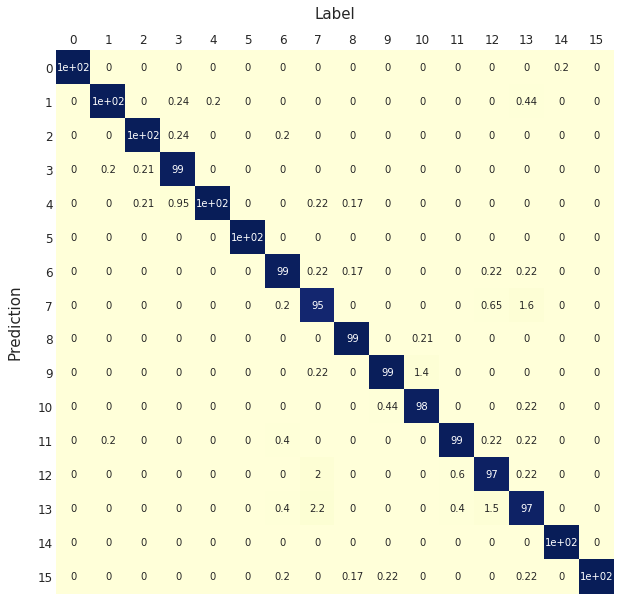

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

graph = sns.heatmap(df_percentage,
                    cmap="YlGnBu",
                    annot=True,
                    cbar=False)
 
            
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

graph.tick_params(axis='both',labelsize=12) # Tick label size
graph.set_yticklabels(graph.get_yticklabels(), rotation = 0, fontsize = 12)
graph.set_ylabel(graph.get_ylabel(), labelpad=15, fontsize = 15)
graph.set_xlabel(graph.get_xlabel(), labelpad=15, fontsize = 15)
plt.savefig(path.split('model.log')[0]+'confusion_matrix_pct', bbox_inches='tight', pad_inches= 0.5)

plt.show()

# wrong predictions

In [17]:
 df[df.Prediction != df.Label].head()

,Prediction,Label,File
116,10,13,13.0.0.0.0121_aug_223.jpg
118,12,7,07.2.2.3.3922.jpg
264,13,12,12.0.2.3.3242_aug_445.jpg
283,7,13,13.0.0.0.0066_aug_504.jpg
436,12,7,07.2.2.3.3935.jpg


### number of all wrong predictions

In [18]:
wrong_number = len(df[df.Prediction != df.Label])
wrong_number

86

### number of all wrong predictions which are augmented

In [19]:
df[df.Prediction != df.Label]['File'].str.count('aug').sum()

79

In [21]:
prediction_list = df[df.Prediction != df.Label]['Prediction'].values.tolist()
label_list = df[df.Prediction != df.Label]['Label'].values.tolist()
labels = ['1', '2', '3', '4', '5', '6', '7.1', '7.2', '8', '9', '10', '11', '12', '13', '14', '15']


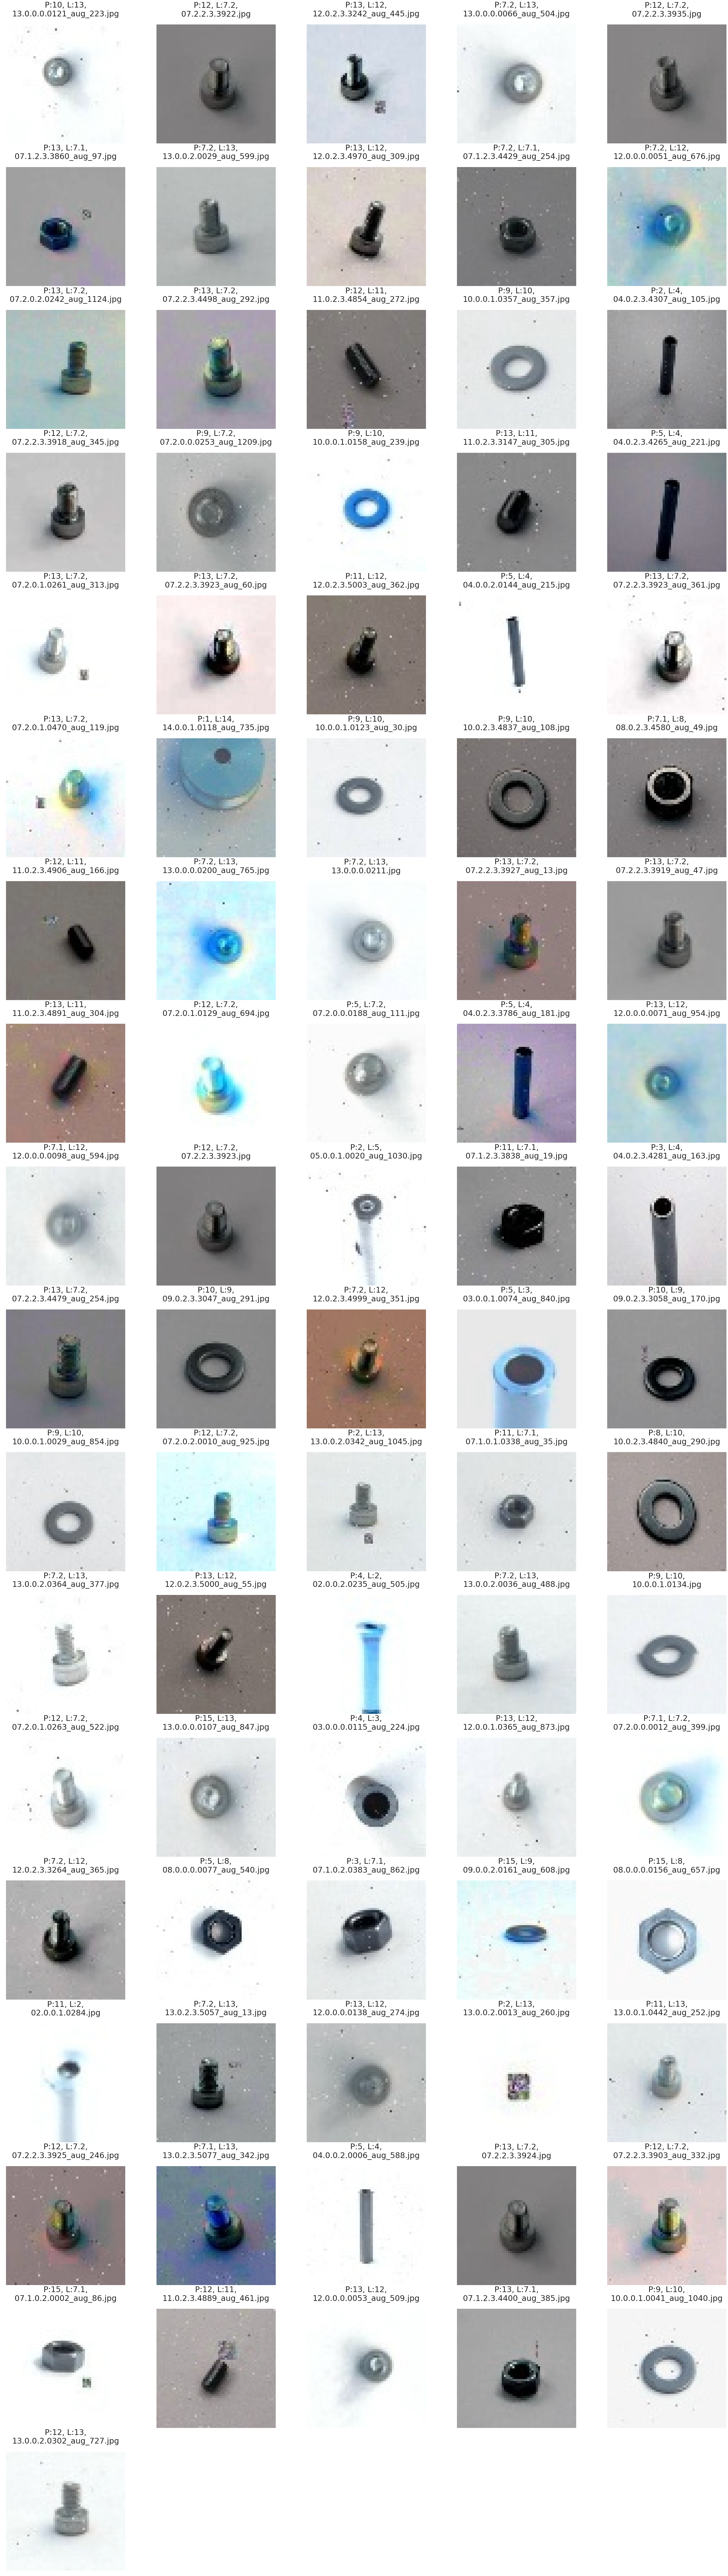

In [23]:
fig = plt.figure(figsize=(50, (wrong_number // 5 + 1) * 10))
for n, image  in enumerate(df[df.Prediction != df.Label]['File'].values.tolist(), 1):
    fig.add_subplot(wrong_number//5 + 1, 5 ,  n)
    file_path = os.path.join(test_path, image)
    plt.axis('off')
    plt.title('P:{}, L:{},\n{}'.format(labels[prediction_list[n-1]], labels[label_list[n-1]], image), fontsize = 30, pad= 30)
    img = cv2.imread(file_path)
    plt.imshow(img)
    
plt.savefig(path.split('model.log')[0]+'wrong_predicted', bbox_inches='tight', pad_inches= 0.5)

plt.show()